# Recap on housing dataset

## 1. Importing Libraries

In [1]:
# import libraries.
from pathlib import Path
import tarfile
import urllib.request
import seaborn as sns

import os


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# scalers.
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# machine learning.
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Transformers
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline

# custom transformers.
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans

# metrics.
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# validation of the model.
from sklearn.model_selection import cross_val_score

# fine-tuning the model.
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import sklearn
sklearn.set_config(display='diagram')




In [2]:
# General formating of the notebook.

sns.set_palette('deep')
sns.set_style("whitegrid")

## 2. Import the Data

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    return pd.read_csv("datasets/housing/housing.csv")

housing = fetch_housing_data()
# housing = pd.read_csv('datasets/housing/housing.csv')

C:\Users\muhum\AppData\Local\Temp\ipykernel_20256\2504118569.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# inspecting unique values in the 'ocean_proximity' column
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## 3. Data visualization

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

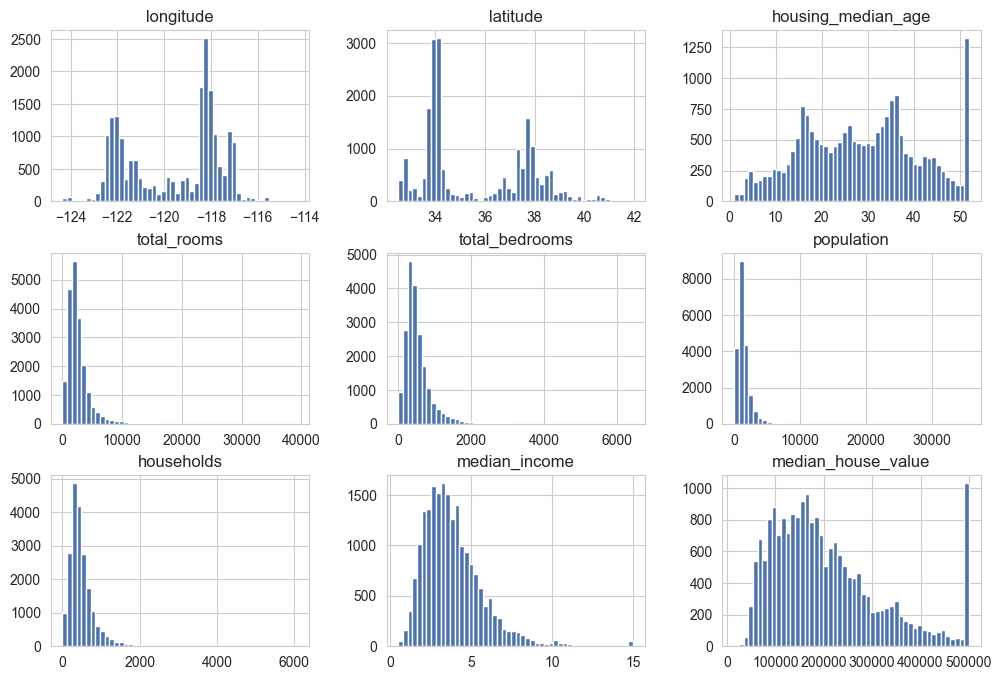

In [8]:
housing.hist(bins=50, figsize=(12,8))

## 4. Create a test set.

The assumption is the dataset is that the `median income` is a great determinant of the value of the `median house value`. As a result, it shall be used to generate stratas before using **stratifed sampling** to come up with the train and test splits.

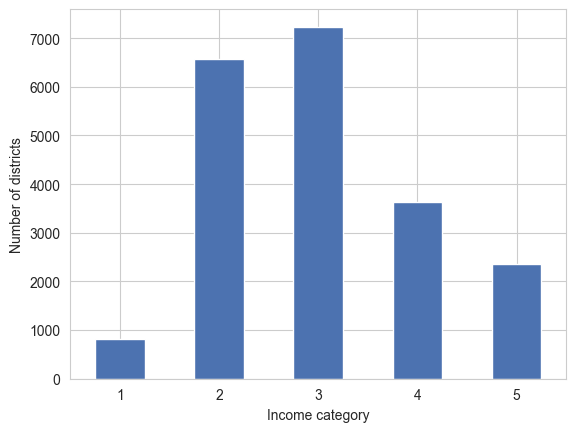

In [9]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0, 1.5, 3.0, 4.5, 6, np.inf],
                               labels=[1, 2, 3, 4, 5])

housing['income_cat'].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [10]:
# stratified sampling using the income cat column.
train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'], random_state = 42)

In [11]:
test_set['income_cat'].value_counts() / len(test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [12]:
train_set['income_cat'].value_counts() / len(train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

The ratios seem fine and satisfying. I will just drop the income cat column.


In [13]:
for set_ in (train_set, test_set):
    set_.drop('income_cat', axis = 1, inplace = True)

## 5. Data Visualization

In [14]:
housing = train_set.copy()

Text(0.5, 1.0, 'Geographical scatterplot of the data')

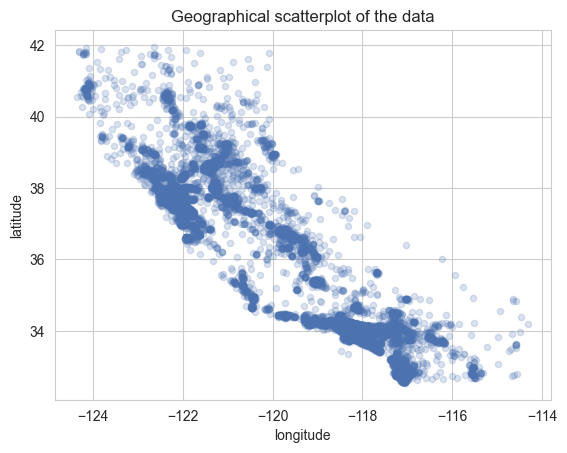

In [15]:
# check the districts.
housing.plot(kind = 'scatter' , x = 'longitude', y = 'latitude', grid = True, alpha = 0.2)
plt.title("Geographical scatterplot of the data")

Further visualization. The diameter of the circle represent the population and the color representing the price.

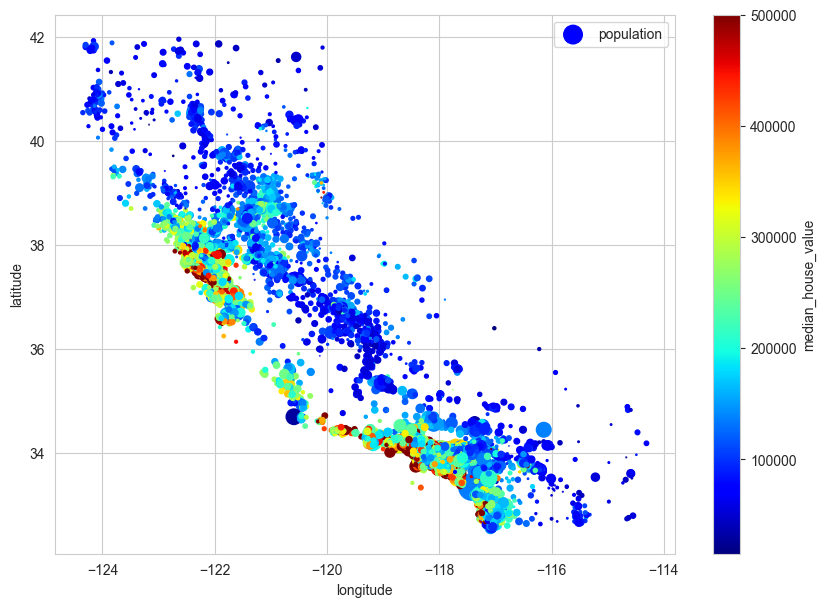

In [16]:
housing.plot(kind= 'scatter', x='longitude', y = 'latitude', grid = True, s=housing['population']/100, label='population',c='median_house_value', cmap='jet', colorbar=True, legend=True, sharex=False, figsize=(10, 7))
plt.show()

Areas with higher population have higher house prices.

In [17]:
print(housing['ocean_proximity'].dtype)

object


<Axes: xlabel='ocean_proximity', ylabel='median_house_value'>

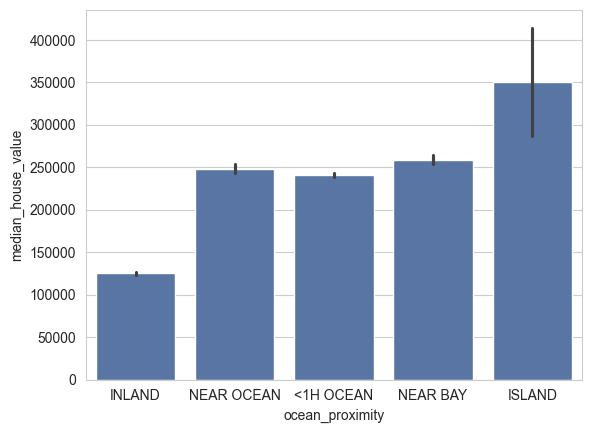

In [18]:
sns.barplot(data = housing, x = 'ocean_proximity', y = 'median_house_value')

<Axes: ylabel='ocean_proximity'>

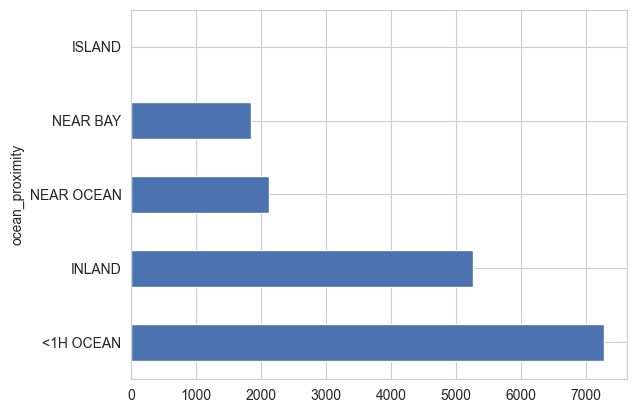

In [19]:
housing['ocean_proximity'].value_counts().plot(kind='barh')

In [20]:
# looking for correlations.
housing.drop('ocean_proximity', axis = 1, inplace=True)
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

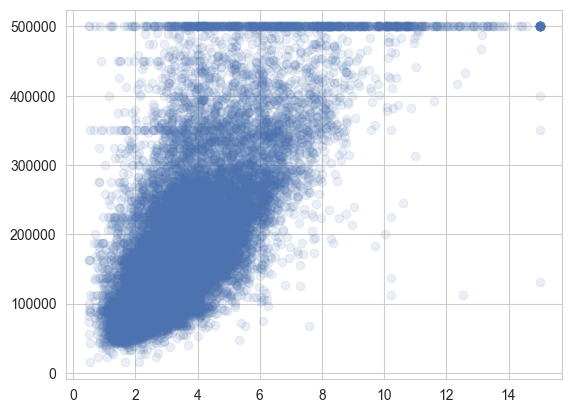

In [21]:
# scatter plot of median income and median house value
plt.scatter(data=housing, x = 'median_income', y = 'median_house_value', alpha=0.1)

#### Experimenting in Feature Engineering

Will involve generation on new columns by combining two or more columns.


In [22]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms']/ housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

In [23]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
rooms_per_house       0.146255
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
people_per_house     -0.021991
population           -0.026882
longitude            -0.047466
latitude             -0.142673
bedrooms_ratio       -0.259952
Name: median_house_value, dtype: float64

In [24]:
del housing
del corr_matrix

## 6. Preparing the dataset for Machine Learning

In [25]:
housing = train_set.drop('median_house_value', axis = 1)
y = train_set['median_house_value'].copy()

In [26]:
# fill missing values in the dataset using simple imputer.

imputer = SimpleImputer(strategy='median')

# pick only the numerical attributes.
housing_num = housing.select_dtypes(include=np.number)

imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [27]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [28]:
X = imputer.transform(housing_num)

In [29]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


### Handling categorical columns


In [30]:
housing_cat = housing[['ocean_proximity']]

In [31]:
# using  ordinal encoding for the categorical column.
ordinal_encoder = OrdinalEncoder()
housing_cat_ordinal = ordinal_encoder.fit_transform(housing_cat)
housing_cat_ordinal[:8]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.]])

The ordinal encoder generated a unique value for each column. This is problematic in that the machine learning algorithm might assume that there is a relationship between the variable, with closer numbers being 'more related' that the categories with higher numbers. This might be more useful in variable with more that have a logical ordering, eg. level of education, rating ('poor', 'fair', 'good', 'very good', 'extremely good') etc. For this case however, `onehot encoding` is the best, in that it provides a binary column for each category.

In [32]:
# using categorical encoding.
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) # generates a sparse matrix.
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [33]:
housing_cat_1hot.toarray() # convert the sparse matrix into an array.

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16512, 5))

In [34]:
cat_encoder.categories_ # get the categories represented.

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 6.1 Feature Scaling and Transformation

#### 6.1.1 MinMaxScaler

Rescales the values to 0-1.
1. Subract the minimum value
2. Divide it by the difference between the minimum and maximum value.

Prone to outliers. 

*feature_range* parameter allows the user to change the range. (if 0 - 1 is not desired.)

In [35]:
scaler = MinMaxScaler()
housing_num_min_max = scaler.fit_transform(housing_num)

#### 6.1.2 Standard Scaler
1. Subtracts the mean value (so that the standardized values have a zero mean.)
2. Divides the result by the standard deviation. (std = 1)

Less prone to outliers.

For a sparse matrix, you can use the standard scaler with its `with_mean` parameter set to *False*. Subtracting the mean would break the sparsity.

In [36]:
scaler = StandardScaler()

housing_num_std_scaler = scaler.fit_transform(housing_num)

Both min-max and standard scaling will quash values to a small range for features with heavy tails. It is important to shrink the tail before  scaling, to make the distributon roughly symmetrical.

Can be achieved in two ways: 
1. **Replacing the features with the square root (or raise to a power between 0 and 1).**
2. **If the tail is very long and heavy, replacing the features with the logarithm might help**
3. *Bucketizing*: **chopping its distribution into roughly equal sized buckets (eg, using the percentiles). Results with features with an  almost uniform distribution, hence, no need to scale further.**

Data with *multimodal* distrubution (has more than one peaks, e.g., the *house_median_age*), it can be helpful to bucketize it. The bucket ID's can be treated as categories.

Another approach will be to add a feature for each of the modes (at least the main ones), representing the similariy between the housing median age and that particular mode.

The simmilarity is typically computed using a *radial bias function(RBF)* - any function that depends only on the distance between the input value and a fixed point. The most common RBF is the Gaussian RBF, whose output value decays exponentially as the input value moves moves away from the fixed point.

The *gamma* value determines how quickly the simmilarity measure decays as x moves away from 35.



In [37]:
age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)

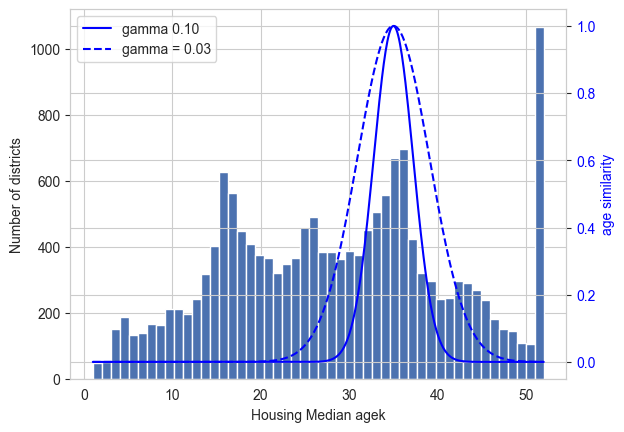

In [38]:
ages = np.linspace(housing['housing_median_age'].min(), housing['housing_median_age'].max(), 500).reshape(-1, 1)

gamma1 = 0.1
gamma2 = 0.03

rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 =rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Housing Median agek')
ax1.set_ylabel("Number of districts")
ax1.hist(housing['housing_median_age'], bins=50)

ax2 = ax1.twinx() # create a twin axis that share the same x-axis
color='blue'
ax2.plot(ages, rbf1, color=color, label = 'gamma 0.10')
ax2.plot(ages, rbf2, color=color, label='gamma = 0.03', linestyle= '--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("age similarity", color= color)

plt.legend(loc='upper left')
plt.show()




It is also important to note that the label needs to be transformed too, if it has a heavy tail. However, the model will now predict a scaled value, which might not be desired.

For this, we have the `inverse_transform()` method, which can be used to compute the inverse of the transformation.

In the code below, the label is scaled using `StandardScaler`, then a simple linear regression model  on the resulting scale labels and use it to make some predictions on some data, with the predictions being transformed back to their original scale using the trained scaler's **inverse_transform()** method.

In [39]:
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(y.to_frame())

model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels) # simple linear regression algorithm.
some_new_data = housing[['median_income']].iloc[:5] # new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
print("Predictions ", predictions)


Predictions  [[135958.75805364]
 [309735.008975  ]
 [165232.3998617 ]
 [138162.41971241]
 [232903.1766333 ]]


This works really fine, but there is a simpler option to use a `TransformedTargerRegressor`.

This is how it shall work:
1. Takes in the regression model and the label transformer.
2. Fits the model on the training set, using the original unscaled labels.
3. It will automatically use the transformer to scale the labels in the training set, and train the model on the resulting scaled labels, just like it was done previously.
4. When making a prediction, it will call the regression model's predict() method and use the scaler's `inverse_transform()` method to produce the prediction.

In [40]:
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

model.fit(housing[['median_income']], y)
predictions = model.predict(some_new_data)
predictions

array([135958.75805364, 309735.008975  , 165232.3998617 , 138162.41971241,
       232903.1766333 ])

## 7. Custom Transformers.

For tranformations that do not require any training, just write a function that takes a Numpy array as input and returns the transformed array. 

For example, to tranform features with heavy tailed distributions by replacing them with their logarithm, you can use the code below:

In [41]:

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[['population']])

The `inverse_func` argument is optional. It assists you to define the inverse transformation function.

In [42]:
# tranformation function taking hyperparameters as additional arguments.
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma = 0.1))
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])

# The rbf transformer has no inverse function coz there are always two values at a given distance from a fixed point.

In [43]:
'''
rbf_kernel() does not treat the features seperately.

Passing an array with two features, it will measure the 2D distance (Euclidean) to measure similarity.

For example:

'''

sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])
sf_simil

array([[0.86435873],
       [0.0076117 ],
       [0.18013578],
       ...,
       [0.94757821],
       [0.9636345 ],
       [0.61315569]], shape=(16512, 1))

In [44]:
# custom tranformers can also be useful when it comes to combining features.
# example, compute the ratio between input feature 0 and 1.

ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])

ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

For trainable transformers, learning some parameters in the fit() method and using them in the transform() method, you need a custom class.

The class must have three,, methods:
1. fit()
2. transform()
3. fit_transform()

*fit_transform()* class can be attained by add the **TransformerMixin** as base class.
*BaseEstimator* class (without *args and **kwargs) in the constructor provides the *get_params()* and *set_params()* methods.

In [45]:
# sample custom tranformer that acts like the Standard Scaler.
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self,with_mean=True):
        self.with_mean = with_mean
    
    def fit(self, X, y=None):
        X = check_array() # checks that X is an array with finite floats.
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1] # every estimator stores this in fit()
        return self # always returns self.
    
    def transform(self, X):
        check_is_fitted() # looks for learned attributes (with trailing _)
        X.check_array()
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X.self.mean_
        return X / self.scale_

The *fit()* must have two arguments, X and y.

The *n_features_in_* ensure that the data passed to transform() or predict() has this number of features.

The *fit()* method must return *self*.


A custom tranformer can (and often does) use  other estimators in its implementation.

In [46]:
class ClusterSimmilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 10, gamma = 1.0, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, name=None):
        return [f"Cluster {i} similarity" for i in range (self.n_clusters)]

# Using the transformer.
cluster_sim = ClusterSimmilarity(n_clusters=10, gamma=1, random_state=42)
similarities = cluster_sim.fit_transform(housing[['latitude', 'longitude']], sample_weight=y)

In [47]:
similarities[:3].round(2)

array([[0.31, 0.  , 0.  , 0.9 , 0.  , 0.01, 0.  , 0.17, 0.  , 0.  ],
       [0.  , 0.12, 0.94, 0.  , 0.  , 0.  , 0.  , 0.  , 0.42, 0.  ],
       [0.  , 0.1 , 0.  , 0.  , 0.43, 0.  , 0.11, 0.  , 0.02, 0.1 ]])

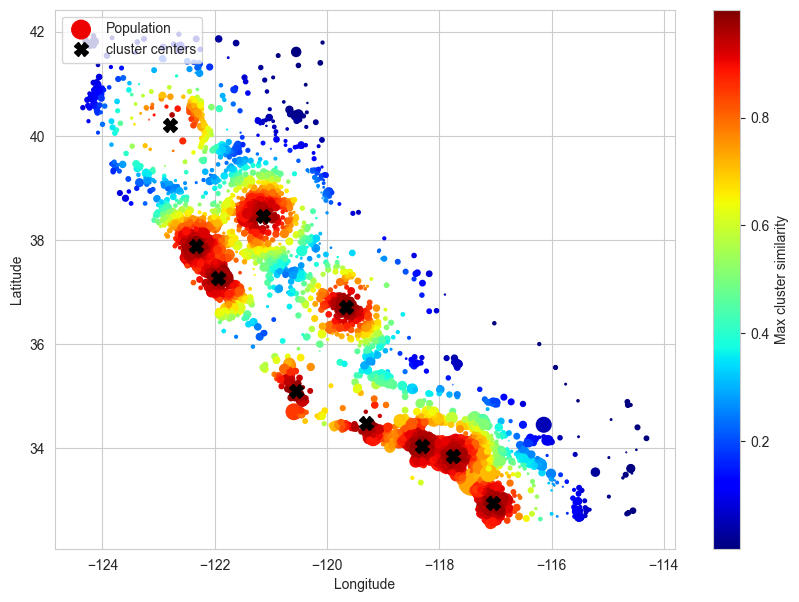

In [48]:
import matplotlib.pyplot as plt


housing_simmilarity = housing.rename(columns={
    "latitude": "Latitude",
    "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median_house_value(usd)"
})

housing_simmilarity["Max cluster similarity"] = similarities.max(axis=1)

housing_simmilarity.plot(kind="scatter", x='Longitude', y='Latitude', grid=True, s=housing_simmilarity['Population']/100, label='Population', c="Max cluster similarity", cmap='jet', colorbar=True, legend=True, sharex=False, figsize=(10, 7))

plt.plot(cluster_sim.kmeans_.cluster_centers_[:, 1],
         cluster_sim.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=10, label="cluster centers")

plt.legend(loc='upper left')

plt.show()


The figure shows the 10 cluster centers found by k-means. The districts are colored according to their geographic similarity to their closest cluster center. Most of the clusters are located in highly populated areas.

## 8. Tranformation Pipelines

Helps arrange all desired tranformations in sequence. For example, to impute values followed by standardization:


In [49]:

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore"))# do not raise an error if an unknown column is provided.
])
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [50]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-0.94,  1.35,  0.03,  0.58,  0.64,  0.73,  0.56, -0.89],
       [ 1.17, -1.19, -1.72,  1.26,  0.78,  0.53,  0.72,  1.29]])

In [51]:
# converting it to a dataframe.
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)
df_housing_num_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752


It is more convinient to handle numerical and categorical transformers together.This is made possible by the `Column Transformer`, applying appropriate transformations to each column.

The `make_column_selector()` function assists in selecting all features of a given type (numerical or categorical).


In [52]:
preprocessing = ColumnTransformer([
    ("num_columns", num_pipeline, make_column_selector(dtype_include=np.number)),
    ("cat_columns", cat_pipeline, make_column_selector(dtype_include=object)),
])

housing_prepared = preprocessing.fit_transform(housing)


In [53]:
# create a dataframe for display purposes only.T
df_housing_prepared = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index = housing.index)
df_housing_prepared.head()

,num_columns__longitude,num_columns__latitude,num_columns__housing_median_age,num_columns__total_rooms,num_columns__total_bedrooms,num_columns__population,num_columns__households,num_columns__median_income,cat_columns__ocean_proximity_<1H OCEAN,cat_columns__ocean_proximity_INLAND,cat_columns__ocean_proximity_ISLAND,cat_columns__ocean_proximity_NEAR BAY,cat_columns__ocean_proximity_NEAR OCEAN
12655,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.0,1.0,0.0,0.0,0.0
15502,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.0,0.0,0.0,0.0,1.0
2908,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,0.0,1.0,0.0,0.0,0.0
14053,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,0.0,0.0,0.0,0.0,1.0
20496,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,1.0,0.0,0.0,0.0,0.0


The pipeline below will perform the following transformations :
1. Missing values in the numerical columns will be *imputed by replacing them with the median*.
2. Missing values in categorical columns will be replaced with *the most frequent category*.
3. The categorical feature will be *onehot encoded*
4. Few ratio features will be generated, *bedrooms_ratio*, *rooms_per_house*, and *people_per_house*.
5. A few cluster similarities will also be added.
6. Features with long tails will be *replaced with their logarithm.*
7. All the numerical columns will be standardized.


In [54]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"] # feature names out.append

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler()
)
cluster_similarity = ClusterSimmilarity(n_clusters=10, gamma=1, random_state=42)
default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', ratio_pipeline(), ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline(), ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
    ('geo', cluster_similarity, ['latitude', 'longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))
], remainder=default_num_pipeline)

In [55]:
housing_prepared = preprocessing.fit_transform(housing)
print(housing_prepared.shape)
preprocessing.get_feature_names_out()

(16512, 24)


array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# 9. Selecting and Training a model.

In [56]:
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimmilarity(gamma=1,
                                                                     random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017F7C87AA80>)])),
                ('linearregression', LinearRegression())])

In [57]:
# first 5 predicitons 
housing_predictions = lin_reg.predict(housing)
print(housing_predictions[:5].round(2))

[ 64709.84 288562.65 183945.19 190166.07 269949.44]


In [58]:
# original values
y.iloc[:5].values

array([ 72100., 279600.,  82700., 112500., 238300.])

In [59]:
# using RMSE to measure the perfomance measure.
lin_rmse = root_mean_squared_error(y, housing_predictions)
lin_rmse

69122.90551084594

The model is underfitting the training set.

In [60]:
# try another model.
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state = 42))
tree_reg.fit(housing, y)

y_pred = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(y, y_pred)
tree_rmse

0.0

There seems to be no error while using DecisionTreeRegressor. However, this might be because the model overfitted.


## 9.1 Evaluation Using Cross Validation.

### 9.1.1 Using the `cross_val_score()` function


In [61]:
tree_rmses = -cross_val_score(tree_reg, housing, y, scoring='neg_root_mean_squared_error', cv=10)

In [62]:
# checking the outcome.
pd.Series(tree_rmses).describe()

count       10.000000
mean     66712.354595
std       3370.842971
min      58898.978399
25%      66156.926321
50%      67038.571047
75%      68962.894079
max      70678.472078
dtype: float64

In [63]:
# calculate the error stats for the linear model.check_inverse
lin_rmses = -cross_val_score(lin_reg, housing, y, scoring='neg_root_mean_squared_error', cv = 10)

pd.Series(lin_rmses).describe()

count       10.000000
mean     71719.749319
std       7703.441831
min      65132.889557
25%      68487.671221
50%      70060.915049
75%      71190.008300
max      92619.956620
dtype: float64

Generally, the Decision Tree is performing better compared to linear regression.

The RMSE of the decision tree is 66712 with a standard deviation of 3370.

In [64]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(forest_reg, housing, y, scoring = 'neg_root_mean_squared_error', cv=10)

pd.Series(forest_rmses).describe()

count       10.000000
mean     47189.772049
std       2540.415366
min      43480.358064
25%      44887.196376
50%      47658.073694
75%      48994.454680
max      51039.231413
dtype: float64

The random Forest performed much more better than the other models. However, there is overfitting, thus the need to fine tune the model.


## 9.2 Fine Tuning the model.

### 9.2.1 Grid Search


In [65]:
# use Grid Search View to identify the optimal hyperparameters for a model.

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ('random_forest', RandomForestRegressor(random_state=42)),
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8],
    },
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]
    },
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000017F7C87AA80>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [66]:
# get the best model.
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [67]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000017...
                                                  ClusterSimmilarity(gamma=1,
                                                                     n_clusters=15,
                                                                     random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017F7C878C20>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [68]:
# get the evaluation scores.
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,42841,43937,44719,43832
6,10,4,43761,44460,45436,44552
13,15,8,43666,44743,45621,44677
9,10,6,44207,44887,45620,44905
7,10,6,44207,44887,45620,44905


### 9.2.2 Randomized Search

Preferable especially when the hyperparameter space is large.

It evaluates a fixed number of combinations, selecting a random value for each hyperparameter at every iteration. Some of the benefits include:
1. Randomized search explores a broader range of hyperparameter values efficiently, unlike grid search, which is limited to predefined options.
2. Randomized search avoids unnecessary computation by not uniformly sampling unimportant hyperparameters, unlike grid search, which scales linearly.
3. Randomized search is more flexible, allowing any number of iterations, while grid search grows exponentially with more hyperparameters.

For each hyperparameter, you must provide a list of possible values or probability distribution.



In [69]:
param_distribs = {
    "preprocessing__geo__n_clusters": randint(low=3, high=50),
    "random_forest__max_features": randint(low=2, high=20)
}

random_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42
)
random_search.fit(housing, y)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017F7C8783B0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017F020212B0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [70]:
cv_res = pd.DataFrame(random_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41581,43026,43080,42563
8,32,7,42081,43592,43490,43054
5,42,4,42005,44527,43529,43354
0,41,16,42525,43716,44291,43510
2,23,8,42729,43630,44221,43527


## 9.3 Analyzing the best Models and their errors.

In [71]:
final_model = random_search.best_estimator_
feature_importances = final_model['random_forest'].feature_importances_
feature_importances.round(2)

array([0.07, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.18, 0.01, 0.01, 0.03,
       0.01, 0.01, 0.01, 0.03, 0.01, 0.  , 0.01, 0.02, 0.02, 0.01, 0.02,
       0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.03,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.02, 0.01, 0.  , 0.01, 0.01, 0.03, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [72]:
# sort the feature importances in descending order and display them next to their corresponding attribute names
sorted(zip(feature_importances, final_model['preprocessing'].get_feature_names_out()),
       reverse=True)

[(np.float64(0.1760250742741092), 'log__median_income'),
 (np.float64(0.07738657647330559), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06896473810374228), 'bedrooms__ratio'),
 (np.float64(0.057972283026865676), 'rooms_per_house__ratio'),
 (np.float64(0.04977836070889518), 'people_per_house__ratio'),
 (np.float64(0.032686570617059936), 'geo__Cluster 43 similarity'),
 (np.float64(0.02902959862506107), 'geo__Cluster 2 similarity'),
 (np.float64(0.025751407736501416), 'geo__Cluster 24 similarity'),
 (np.float64(0.025137731063364196), 'geo__Cluster 6 similarity'),
 (np.float64(0.02258334432605079), 'geo__Cluster 10 similarity'),
 (np.float64(0.018311640927452456), 'geo__Cluster 11 similarity'),
 (np.float64(0.0175455704933612), 'geo__Cluster 15 similarity'),
 (np.float64(0.016259209882534452), 'geo__Cluster 13 similarity'),
 (np.float64(0.015141217898400323), 'geo__Cluster 38 similarity'),
 (np.float64(0.014849142748469636), 'geo__Cluster 1 similarity'),
 (np.float64(0.01474190562589846

# 10. Evaluate the model on the test set.

In [73]:
X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value']

In [74]:
final_predictions = final_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
final_rmse

39779.37181076267

Better than the training error. Good to go.

In [75]:
# calcute a 95% confidence  interval for the generelization error
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([37902.28905288, 41571.78523795])

# Launch, Monitor and Maintain the system.


In [76]:
# import joblib
# joblib.dump(final_model, "my_california_housing_model.pkl")

In [77]:
# final_model_reloaded = joblib.load('my_california_housing_model.pkl')
# new_data = housing.iloc[:5]


# predictions = final_model_reloaded.predict(new_data)
# predictions

In [78]:
import dill

# Save the trained model using dill
with open("price_predict.pkl", "wb") as f:
    dill.dump(final_model, f)

# Reload the saved model
with open("price_predict.pkl", "rb") as f:
    final_model_reloaded = dill.load(f)

# Select new data for testing
new_data = housing.iloc[:5]

# Make predictions
predictions = final_model_reloaded.predict(new_data)

# Output predictions
print(predictions)


[ 74639.   297002.03  81143.   121620.   228629.  ]


In [79]:
housing.iloc[:5]


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
